/home/alice/anaconda3/envs/lowergcc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alice/Bartons/Generative/VQVAE/utils.py:13: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(t.shape[0] == grid[0]*grid[1], "grid size must match the number of elements in the first(batch) dimension")


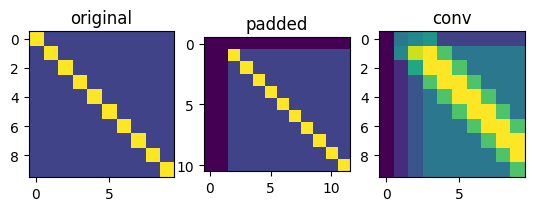

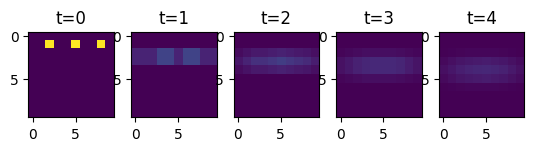

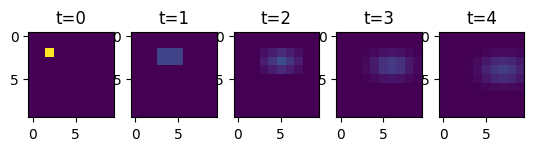

In [1]:
%load_ext autoreload
%autoreload 2

from pixelsnail import *
import torch
import matplotlib.pyplot as plt
import numpy as np

t = torch.eye(10, 10).view(1, 1, 10, 10) + 0.2
fig, ax = plt.subplots(1, 3)
ax[0].imshow(t[0].permute(1, 2, 0).detach().numpy(), vmin=0, vmax=1)
ax[0].set_title("original")

ker_v, ker_h = (2, 3)
pad = [ker_h-1, 0, ker_v-1, 0]
pad = nn.ZeroPad2d(pad)
out = pad(t)
ax[1].imshow(out[0].permute(1, 2, 0).detach().numpy(), vmin=0, vmax=1)
ax[1].set_title("padded")

conv = nn.Conv2d(1, 1, (2, 3),
    stride=1, padding=0, bias=None)
conv.weight.data.fill_(0.33)

out = conv(out)
out = shift_right(out)
ax[2].imshow(out[0].permute(1, 2, 0).detach().numpy(), vmin=0, vmax=1)
ax[2].set_title("conv")

## experiment down
fig, ax = plt.subplots(1, 5)
casual_conv = CausalConv2d(1, 1, (2, 5), mode="down", weight_norm=False)
casual_conv.conv.weight.data.fill_(1/10)
casual_conv.conv.bias.data.fill_(0.00)

t = torch.zeros(1, 1, 10, 10)
t[:,:,1,2]=1.0
t[:,:,1,5]=1.0
t[:,:,1,8]=1.0
ax[0].imshow(t[0].permute(1, 2, 0).detach().numpy())
out = t
ax[0].set_title(f"t=0")

for i in range(4):
    out = casual_conv(out)
    if i == 0: out = shift_down(out)
    out_img = out[0].permute(1, 2, 0).detach().numpy()
    cx = ax[i+1].imshow(out_img,vmin=0, vmax=1)
    ax[i+1].set_title(f"t={i+1}")
    
## experiment downright
fig, ax = plt.subplots(1, 5)
casual_conv = CausalConv2d(1, 1, (2, 3), mode="downright", weight_norm=False)
casual_conv.conv.weight.data.fill_(0.2)
casual_conv.conv.bias.data.fill_(0.00)
 
t = torch.zeros(1, 1, 10, 10)
t[:,:,2, 2]=1.0
ax[0].imshow(t[0].permute(1, 2, 0).detach().numpy())
out = t
ax[0].set_title(f"t=0")

for i in range(4):
    out = casual_conv(out)
    if i == 0: out = shift_right(out)
    out_img = out[0].permute(1, 2, 0).detach().numpy()
    cx = ax[i+1].imshow(out_img,vmin=0, vmax=1)
    ax[i+1].set_title(f"t={i+1}")

In [1]:
%load_ext autoreload
%autoreload 2

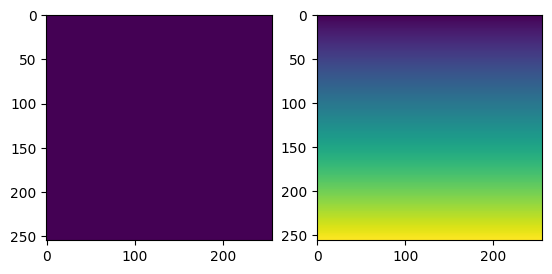

In [11]:
height = 256
width = 256
coord_y = (torch.arange(height).float() - height / 2) / height
coord_y = coord_y.view(1, 1, height, 1).expand(1, 1, height, width)
coord_x = (torch.arange(width).float() - width / 2) / width
coord_x = coord_x.view(1, 1, 1, width).expand(1, 1, height, width)
back0 = torch.full((1, 1, 255, 255), 0.5)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(back0[0].permute(1, 2, 0).detach().numpy())
ax[1].imshow(coord_y[0].permute(1, 2, 0).detach().numpy())

torch.Size([1, 1, 10, 10])
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.3990e-04,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  7.0941e-03, -3.4403e-02, -2.7205e-03,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 8.3165e-03, -4.2899e-02, -7.8889e-03, -8.1779e-02,  2.7733e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-4.3639e-02,  2.4233e-02, -2.1554e-02, -4.9331e-02,  6.0063e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 3.5803e-02,  1.4396e-02, -4.0525e-02,  2.8005e-02, -1.1230e-02,
     

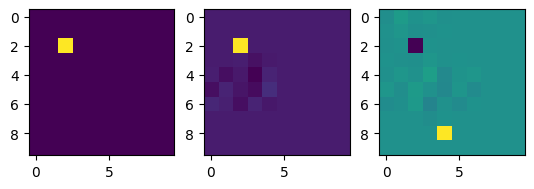

In [39]:
from pixelsnail import PixelSnail
#snail = PixelSnail(10, 1, 10, (10, 10))

x = torch.zeros(1, 1, 10, 10)
x[0, 0, 2, 2] = 1.0
x.requires_grad = True

blocks = [GatedResBlock(1, (3, 3), 1, dropout=0.0, bias=False, mode="causal") for i in range(1)]
out = x
for block in blocks:
    out = block(out)
    
s = torch.zeros(1, 1, 10, 10)
s[0, 0, 8, 4] = 1.0
s.requires_grad = False
criterion = nn.MSELoss()
loss = -criterion(out ,s)

loss.backward()
print(out.shape)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(x[0].permute(1, 2, 0).detach().numpy())
ax[1].imshow(out[0].permute(1, 2, 0).detach().numpy())
ax[2].imshow(x.grad[0].permute(1, 2, 0).detach().numpy())
print(out[0].permute(1, 2, 0)[:, :, 0])

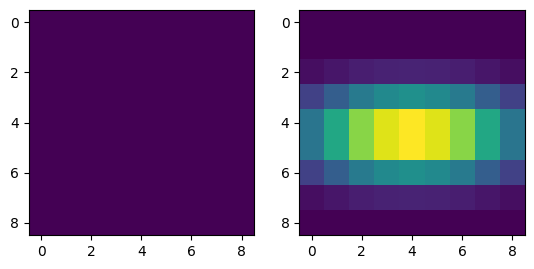

In [38]:
## experiment down
fig, ax = plt.subplots(1, 2)
casual_conv = CausalConv2d(1, 1, (2, 5), mode="down", weight_norm=False)
casual_conv.conv.weight.data.fill_(1.0)
casual_conv.conv.bias.data.fill_(0.00)

t = torch.zeros(1, 1, 9, 9)
t.requires_grad = True
out = shift_down(casual_conv(t))
out = casual_conv(out)
out = casual_conv(out)
out = casual_conv(out)
out = casual_conv(out)
ax[0].imshow(out[0].permute(1, 2, 0).detach().numpy())

s = torch.zeros(1, 1, 9, 9)
s[0, 0, 8, 4] = 1.0
s.requires_grad = False
criterion = nn.MSELoss()
loss = -criterion(out ,s)
loss.backward()

ax[1].imshow(t.grad[0].permute(1, 2, 0).detach().numpy())


In [1]:
from vqvae import QuantizedEmbedding
import torch

QE = QuantizedEmbedding(3, 2)
means = torch.Tensor([
    [-1.0, 1.0],
    [0., -1.0],
    [1.0, 1.0],
])
ze= torch.Tensor(0, 2)
for i in range(3):
    ze = torch.cat([ze, torch.randn((5, 2))*0.5 + means[i]], 0)
    
QE.forward(ze)

/home/alice/anaconda3/envs/lowergcc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(tensor([[-1.,  0.],
         [-1.,  0.],
         [-1.,  0.],
         [-1.,  0.],
         [-1.,  0.],
         [ 1.,  0.],
         [-1.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.],
         [ 1.,  0.]]),
 tensor([0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 1, 2, 2, 2, 2]),
 tensor(0.6738))

In [1]:
import json
import requests
from collections import OrderedDict
import queue
import os
import hashlib
import glob

with open('data/ffhq-dataset-v2.json', 'rb') as f:
    json_data = json.load(f, object_pairs_hook=OrderedDict)

DATA_DIR = 'data/ffhq_images/images_original/'
specs = [item['image'] for item in json_data.values()]
specs = specs[:5000]
spec_queue = queue.Queue()
for i in range(len(specs)):
    spec_queue.put(specs[i])

print("downloading ", len(specs), "images to ", DATA_DIR)

N = len(specs)
success = 0

with requests.Session() as session:
    while not spec_queue.empty():
        spec = spec_queue.get()
        file_url = spec['file_url']
        file_path = os.path.join(DATA_DIR, spec['file_path'])
        tmp_path = os.path.join(DATA_DIR, spec['file_path']+'.tmp')
        # create directory
        file_dir = os.path.dirname(file_path)
        if file_dir:
            os.makedirs(file_dir, exist_ok=True)
            
        for attempts_left in reversed(range(3)):
            data_size = 0
            try:
                data_md5 = hashlib.md5()
                with session.get(file_url, stream=True) as res:
                    res.raise_for_status()
                    with open(tmp_path, 'wb') as f:
                        for chunk in res.iter_content(chunk_size=128<<10):
                            f.write(chunk)
                            data_size += len(chunk)
                            data_md5.update(chunk)
                # check correctness
                if 'file_md5' in spec and data_md5.hexdigest() != spec['file_md5']:
                    raise IOError('Incorrect file MD5', file_path)
                continue
            except:
                # kwnon error
                if data_size > 0 and data_size < 8192:
                    with open(tmp_path, 'rb') as f:
                        data = f.read()
                    data_str = data.decode('utf-8')
                    if 'Google Drive - Quota exceeded' in data_str:
                        if not attempts_left:
                            print(data_str)
                            raise IOError("Google Drive download quota exceeded -- please try again later")
                # unhandled error
                if not attempts_left: 
                    print("unhandled error")
                    raise #something's wrong
        
        # remove old file
        os.replace(tmp_path, file_path)
        for filename in glob.glob(file_path + '.tmp'):
            os.remove(filename)
        
        success += 1
        if success % 1000 == 0:
            print(success / N)

downloading  5000 images to  data/ffhq_images/images_original/
<!DOCTYPE html><html><head><title>Google Drive - Quota exceeded</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/><style nonce="Dh7tHBHnptb7w3NrqJSp5g">.goog-link-button{position:relative;color:#15c;text-decoration:underline;cursor:pointer}.goog-link-button-disabled{color:#ccc;text-decoration:none;cursor:default}body{color:#222;font:normal 13px/1.4 arial,sans-serif;margin:0}.grecaptcha-badge{visibility:hidden}.uc-main{padding-top:50px;text-align:center}#uc-dl-icon{display:inline-block;margin-top:16px;padding-right:1em;vertical-align:top}#uc-text{display:inline-block;max-width:68ex;text-align:left}.uc-error-caption,.uc-warning-caption{color:#222;font-size:16px}#uc-download-link{text-decoration:none}.uc-name-size a{color:#15c;text-decoration:none}.uc-name-size a:visited{color:#61c;text-decoration:none}.uc-name-size a:active{color:#d14836;text-decoration:none}.uc-footer{color:#777;font-size:11px;paddin

OSError: Google Drive download quota exceeded -- please try again later

create memory efficient dataset from data  VQVAE/data/ffhq_images
processing  data/ffhq_images/images_resized_00000
	total image cnt:  2000


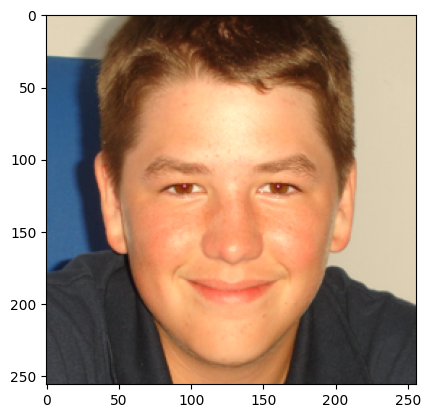

In [13]:
from dataset import FFHQDataset
import matplotlib.pyplot as plt
DATA_DIR = 'data/ffhq_images'
train_data = FFHQDataset(data_dir=DATA_DIR)

img = train_data[1002]
plt.imshow(img.permute(1, 2, 0).numpy())

